# import and functions 

In [8]:
import ast
from tqdm import tqdm
from ast import literal_eval
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from scipy.signal import hilbert, convolve
import json

def load_in_sleep_state_scoring(mouse):
    print('---------------------')
    print('searching for sleep state scoring')
    # determine organised data paths for the current mouse
    if mouse.split('_')[0].isdigit():
        org_dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
        old_data = True
    else:
        org_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
        old_data = False
    org_mouse_file = None
    for file in os.listdir(org_dat_path):
        if mouse.split('_')[0] in file:
            # if the implant = implant
            if mouse.split('_')[1] == file.split('_')[-1][-1]:
                print(f'1. mouse file found: \033[1m{file}\033[0m')
                org_mouse_file = os.path.join(org_dat_path,file)
    mouse_org_data_path = None
    for recording in os.listdir(org_mouse_file):
        if mouse.split('_')[-1] == recording.split('_')[0][-1]:
            print(f'2. recording found: \033[1m{recording}\033[0m')
            mouse_org_data_path = os.path.join(org_mouse_file,recording) + r'\\'

    # load in sleep scoring data 
    sleep_state_score_path = mouse_org_data_path + r"\ephys\LFP\\sleep_state_score\\"
    if not os.path.exists(sleep_state_score_path):
        print(f"Sleep state score files not found for {mouse}.")
    else:
        nrem_start_ends = np.load(sleep_state_score_path + "nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "rem_start_ends.npy", allow_pickle=True)
        print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")
    
    print('----------------------')
        
    return nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data

##################################

def load_in_replay_data(mouse,old_data_bool):
    
    print('---------------------')
    print('searching for replay data')
    if old_data_bool:
        dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"
    else:
        dat_path = ERROR_REPLACE_ME

    pp_path = 'SKIP'
    for file in os.listdir(dat_path):
        if mouse in file:
            print(f'file found: \033[1m{file}\033[0m')
            pp_path = os.path.join(dat_path,file)
    
    if pp_path == 'SKIP':
        return None,'SKIP'
    replay_data_path = pp_path + r'\analysis_output\\'

    params_file = pp_path + r'\trainingData\\' + 'params_' + mouse + '.json'
    with open(params_file, 'r') as file:
        params = json.load(file)
    time_spans = params['time_span']
    
    replay_events_df = pd.DataFrame({})
    start_offset = []
    for file in os.listdir(replay_data_path):
        if 'chunk' in file:
            print(file)

            chunk_number = int(file.split('_')[0][-1])

            start_offs = ([0]+list(np.cumsum(np.diff(time_spans))))[chunk_number-1]
            start_offset +=[start_offs]


            print(replay_data_path)

            df_load = pd.read_csv(replay_data_path + file + r'\filtered_replay_clusters_df.csv',index_col=0)
            df_load['chunk'] = [chunk_number]*len(df_load)
            
            df_load['chunk_time'] = [time_spans[chunk_number-1]]*len(df_load)
            fs_times_ephys_time = (df_load.first_spike_time.values - start_offs)
            df_load['first_spike_ephys_time'] = fs_times_ephys_time
            df_load["replay_abs_time"] = df_load['chunk_time'].values[0][0] + df_load["first_spike_ephys_time"] + df_load["event_length"]/2
            replay_events_df = pd.concat((replay_events_df,df_load),axis =0)
            replay_events_df.reset_index(drop = True)

    # if mouse == '178_1_7':              
    #     spikes_file = os.path.join(pp_path,'trainingData\\') + mouse + '.txt'
    #     neuron_ids, spike_times= [], []
    #     with open(spikes_file) as f:
    #         for (i, line) in enumerate(f.readlines()):
    #             [neuron_id, spike_time] = line.split(' ', 1)
    #             spike_time = eval(spike_time.split('\n')[0])
    #             neuron_id = eval(neuron_id.split('\t')[0])
    #             spike_times.append(spike_time)
    #             neuron_ids.append(neuron_id)
    #     spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 

    #     print (f"\033[1mSuccess!\033[0m Loaded replay data files for mouse: {mouse}.")
    #     print('---------------------')
    #     return replay_events_df,spikes_df
    # else:
    print (f"\033[1mSuccess!\033[0m Loaded replay data files for mouse: {mouse}.")
    print('---------------------')
    return replay_events_df, None

def find_awake_file_ppseq_path(mouse,ppseq_path):
    if any([mouse in file for file in os.listdir(ppseq_path + r'expert/awake//')]) == True:
        file_ind = np.where(np.array([mouse in file for file in os.listdir(ppseq_path + r'expert/awake//')]) == True)[0][0]
        awake_file_path = os.path.join(ppseq_path, r'expert/awake', os.listdir(ppseq_path + r'expert/awake//')[file_ind])
    elif any([mouse in file for file in os.listdir(ppseq_path + r'learning/awake//')]) == True:    
        file_ind = np.where(np.array([mouse in file for file in os.listdir(ppseq_path + r'learning/awake//')]) == True)[0][0]
        awake_file_path = os.path.join(ppseq_path, r'learning/awake', os.listdir(ppseq_path + r'learning/awake//')[file_ind])
    else:
        print('awake file not found for mouse: ' + mouse)
    return awake_file_path

def load_sync_file(mouse_org_data_path,mouse):
    current_animals_behav_sync_path = os.path.join(mouse_org_data_path, r"behav_sync\\")
    for stage in os.listdir(current_animals_behav_sync_path):
        if 'post' in stage:
            sync_path = current_animals_behav_sync_path + stage + '\\'
    if mouse == '148_2_2':
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv', encoding='cp1252')
    else:
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv')
        
    return sync_df 

def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups

def plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, time_window, bin_size):
    """
    Plots spike raster and sequence histogram for a given sequence type.
    """
    # Filter spikes within the plotting window
    mask = (unmasked_spikes_df.timestamp > time_window[0]) & (unmasked_spikes_df.timestamp < time_window[1])
    visible_spikes = unmasked_spikes_df[mask]
    valid_seq_mask = visible_spikes.sequence_type_adjusted >= 0
    spike_colors = np.array(colors)[visible_spikes[valid_seq_mask].sequence_type_adjusted.values.astype(int)]

    # Spike raster
    ax1.scatter(
        visible_spikes[valid_seq_mask].timestamp,
        awake_neuron_order[mask][valid_seq_mask],
        marker='o', s=40, linewidth=0, color=spike_colors, alpha=1
    )

    # Histogram and detected groups
    ax2.plot(seq_spike_count, color=colors[i])
    for start, end in groups:
        ax2.plot([start, end], [-5, -5], color='red')

    ax1.set_xlim([time_window[0], time_window[-1]])
    ax2.set_xlim(time_window[0]/bin_size,time_window[-1] / bin_size)



def extract_sequence_events(df, sequence_type, groups, bin_size, seq_size_threshold):
    """
    Extracts spike events from continuous groups of time bins for a specific sequence type.
    """
    extracted = []

    for start, end in groups:
        group_start_time = (start * bin_size) - 0.5
        group_end_time = (end * bin_size) + 0.5

        time_mask = (df.timestamp > group_start_time) & (df.timestamp < group_end_time)
        group_spikes = df[time_mask]
        matching_seq = group_spikes[group_spikes.sequence_type_adjusted == sequence_type]

        if len(matching_seq) > seq_size_threshold:
            extracted.append(matching_seq)

    return extracted


def process_awake_data_return_seq_dfs(unmasked_spikes_df, chunk_time, awake_neuron_order, colors, plotting_limit,bin_size=0.2, seq_size_threshold=5):
    """
    Processes spike data to extract time-localized spike events for each sequence type (1–6).
    """
    seq_types = np.unique(unmasked_spikes_df.sequence_type_adjusted)

    # Gather spike timestamps by sequence type
    seq_spikes = [unmasked_spikes_df.timestamp[unmasked_spikes_df.sequence_type_adjusted == seq_type].values for seq_type in seq_types]

    # Compute binned spike histograms
    seq_spike_occurrence = [list(np.histogram(spikes, bins=np.arange(0, np.diff(chunk_time)[0], bin_size))[0]) for spikes in seq_spikes]

    seq_event_dfs = []
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
    for i in range(1, 7):  # process sequence types 1–6
        print(f"Processing sequence type: {i}")
        seq_spike_count = seq_spike_occurrence[i]
        groups = return_inds_for_seq_groups(seq_spike_count)

        # Plot sequence summary (raster + histogram)
        plot_sequence_summary(ax1,ax2,unmasked_spikes_df, awake_neuron_order, colors, seq_spike_count, groups, i, plotting_limit,bin_size)

        # Extract sequence events as separate DataFrames
        seq_event_dfs.extend(
            extract_sequence_events(unmasked_spikes_df, i, groups, bin_size, seq_size_threshold)
        )

    return seq_event_dfs

def find_events(signal_data, lower_threshold, upper_threshold, sampling_rate,time_filter,offset):
    events = []
    event_start = None
    peak_magnitude = None
    sum_magnitude = 0
    count_samples = 0

    for i, sample in enumerate(signal_data):
        # Check if the signal crosses the lower threshold
        if sample > lower_threshold:
            if event_start is None:
                event_start = i

            # Check if the signal crosses the upper threshold within the event window
            if sample > upper_threshold:
                peak_magnitude = max(signal_data[event_start:i + 1])
                sum_magnitude += sample
                count_samples += 1

        else:
            # If the event window duration is at least the time filter (s * sampling_rate)
            if event_start is not None and (i - event_start) >= (time_filter * sampling_rate):
                if peak_magnitude is not None and peak_magnitude > upper_threshold:
                    average_magnitude = sum_magnitude / count_samples
                    events.append({
                        "start_time": (event_start / sampling_rate)+offset,
                        "end_time": (i / sampling_rate)+offset,
                        "peak_magnitude": peak_magnitude,
                        'magnitude': sum_magnitude,
                        "average_magnitude": average_magnitude,
                    })

            # Reset event variables
            event_start = None
            peak_magnitude = None
            sum_magnitude = 0
            count_samples = 0

    return events

def determine_awake_neuron_motif_involvements(unmasked_spikes_df, seq_event_dfs):

    seq_by_seq_awake_mean_neuron_motif_involvements = []
    ### determine which neurons are involved in awake seqs
    all_neurons_list = list(np.unique(unmasked_spikes_df.neuron))
    for seq_type in range(1,7):
        # print(seq_type)
        # Determine mean neuron involvements for awake
        neuron_motif_involvements = [[] for _ in range(len(all_neurons_list))]
        for awake_seq in seq_event_dfs:
            if awake_seq.sequence_type_adjusted.values[0] == seq_type:
                for id_, neuron_id in enumerate(all_neurons_list):
                    if neuron_id in awake_seq.neuron.values:
                        neuron_motif_involvements[id_].append(1)
                    else:
                        neuron_motif_involvements[id_].append(0)
        #find mean involvements:
        awake_mean_neuron_motif_involvements = []
        for item in neuron_motif_involvements:
            if len(item)>0:
                awake_mean_neuron_motif_involvements += [sum(item)/len(item)]
            else:
                awake_mean_neuron_motif_involvements += [0]
        seq_by_seq_awake_mean_neuron_motif_involvements += [awake_mean_neuron_motif_involvements]
    return seq_by_seq_awake_mean_neuron_motif_involvements

def define_spindle_linkage(spindle_events,replay_times):
    spindle_linkage_distance = []
    for event in replay_times:
        current_shortest_dist = 999999
        for spin_mid in spindle_events:
            distance = abs(spin_mid - event)
            if distance < abs(current_shortest_dist):
                current_shortest_dist = (spin_mid - event)
        spindle_linkage_distance += [current_shortest_dist]
    return spindle_linkage_distance

def filter_for_spindles_and_plot(spindle_bandpassed,nrem_intervals,rem_intervals,fs,min_event_duration,sleep_period_ephys_start_time):

    time = np.arange(len(spindle_bandpassed)) / fs
    # adjust time to account for trimmed down ephys lfp
    time += sleep_period_ephys_start_time

    # Compute the smoothed envelope
    smoothed_envelope = compute_smoothed_envelope(spindle_bandpassed, fs)

    ## filter for NREM sleep times only and find mean and s-dev
    nrem_envelope_perioids = []
    for interval in nrem_intervals:
        nrem_envelope_perioids += list(smoothed_envelope[(time > interval[0]) * (time < interval[1])])
    mean_ = np.mean(nrem_envelope_perioids)
    std_ = np.std(nrem_envelope_perioids)

    upper_threshold = mean_ + 2*std_
    lower_threshold = mean_ + 1*std_

    # Plotting the original signal and the smoothed envelope
    fig, [ax,ax2] = plt.subplots(2, 1,figsize=(20, 10))
    ax.plot(time, spindle_bandpassed, color='b')
    ax.plot(time, smoothed_envelope, label='Smoothed Envelope', color='r')
    ax.axhline(upper_threshold,color = 'c')
    ax.axhline(lower_threshold,color = 'c')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    ax.set_xlim(sleep_period_ephys_start_time+100,sleep_period_ephys_start_time+120)
    ax.set_ylim((-1*upper_threshold)-(0.6*upper_threshold),upper_threshold +(0.6*upper_threshold))

    ## filter for spindles

    offset = sleep_period_ephys_start_time
    spindle_events = find_events(smoothed_envelope,lower_threshold, upper_threshold,fs,min_event_duration,offset)

    ax2.plot(time, spindle_bandpassed, color='b')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Amplitude')

    for event in spindle_events:
        ax2.axvspan(event['start_time'],event['end_time'], alpha=0.5, color='red')
        
    ax2.set_ylim((-1*upper_threshold)-(1.5*upper_threshold),upper_threshold +(1.5*upper_threshold))


    # Add shaded regions without repeating labels
    for ind, (start, end) in enumerate(rem_intervals):
        label = 'rem' if ind == 0 else None
        ax2.axvspan(start, end, color='yellow', alpha=0.2, label=label)

    for ind, (start, end) in enumerate(nrem_intervals):
        label = 'nrem' if ind == 0 else None
        ax2.axvspan(start, end, color='green', alpha=0.2, label=label)

    ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.2))
    
    return spindle_events,smoothed_envelope

def compute_smoothed_envelope(signal, sampling_rate, window_length_ms=200):
    # Convert window length from milliseconds to samples
    window_length_samples = int(window_length_ms * sampling_rate / 1000)
    
    # Compute the analytic signal using Hilbert transform
    analytic_signal = hilbert(signal)
    
    # Compute the magnitude of the analytic signal
    magnitude = np.abs(analytic_signal)
    
    # Create a Gaussian window with specified length
    gaussian_window = np.exp(-0.5 * (np.arange(-window_length_samples, window_length_samples+1) / (0.001 * sampling_rate))**2)
    
    # Normalize the Gaussian window
    gaussian_window /= np.sum(gaussian_window)
    
    # Convolve the magnitude with the Gaussian window
    smoothed_envelope = convolve(magnitude, gaussian_window, mode='same')
    
    return smoothed_envelope


# notes

In [ ]:
# the idea is...can we predict if a spindle will be close to replay events based on features of the replay events?

# it could be that a specific replay seq is more likley?
# it could be that indipendnet of sequence type, replay features predict closeness to spindles

# one regression which is just each motif type

# then posthoc some kind of analysis of this? 
# I think i dont care about the specific replay type, I just want to know how many domniate 

####---------------------------------------------


###STEP1: linear regression, can you predict closeness to spindle based on seq type?
# if yes ...
#step 1: mean linkage distance for each seq type.
#step 2: for each subject, how many are significantly different from each other?
# if they are different, are they task related or not?
# and are they positive or negative from average linkage distance?
# plots: ....

#####STEP2: Do replay features predict closeness to spindles?
# linear regression, can you predict closeness to spindle based on replay features?
# plot the features etc. 
# and then do some posthoc analysis of the features that predict closeness to spindles?

# one that is features of all replay 

# main

mouse name is: 136_1_3
---------------------
searching for sleep state scoring
1. mouse file found: EJT136_implant1
2. recording found: recording3_11-11-2021
Success! Loaded sleep state score files for mouse: 136_1_3.
----------------------
---------------------
searching for replay data
file found: 136_1_3_run_1007023_2048
chunk1_8700to9300
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
chunk2_10000to11600
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
chunk3_11900to12500
Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\136_1_3_run_1007023_2048\analysis_output\\
Success! Loaded replay data files for mouse: 136_1_3.
---------------------


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_61896\1902805134.py:107: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == mouse].dominant_task_seqs)


Processing sequence type: 1
Processing sequence type: 2
Processing sequence type: 3
Processing sequence type: 4
Processing sequence type: 5
Processing sequence type: 6


100%|██████████| 4246/4246 [00:00<00:00, 7981.43it/s]


Optimization terminated successfully.
         Current function value: 0.384712
         Iterations 7
                             Logit Regression Results                            
Dep. Variable:     spindle_linage_binary   No. Observations:                 4246
Model:                             Logit   Df Residuals:                     4236
Method:                              MLE   Df Model:                            9
Date:                   Tue, 08 Jul 2025   Pseudo R-squ.:                 0.01570
Time:                           11:17:13   Log-Likelihood:                -1633.5
converged:                          True   LL-Null:                       -1659.5
Covariance Type:               nonrobust   LLR p-value:                 4.311e-08
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.8857      0.086    -21.963      0.000      -2.

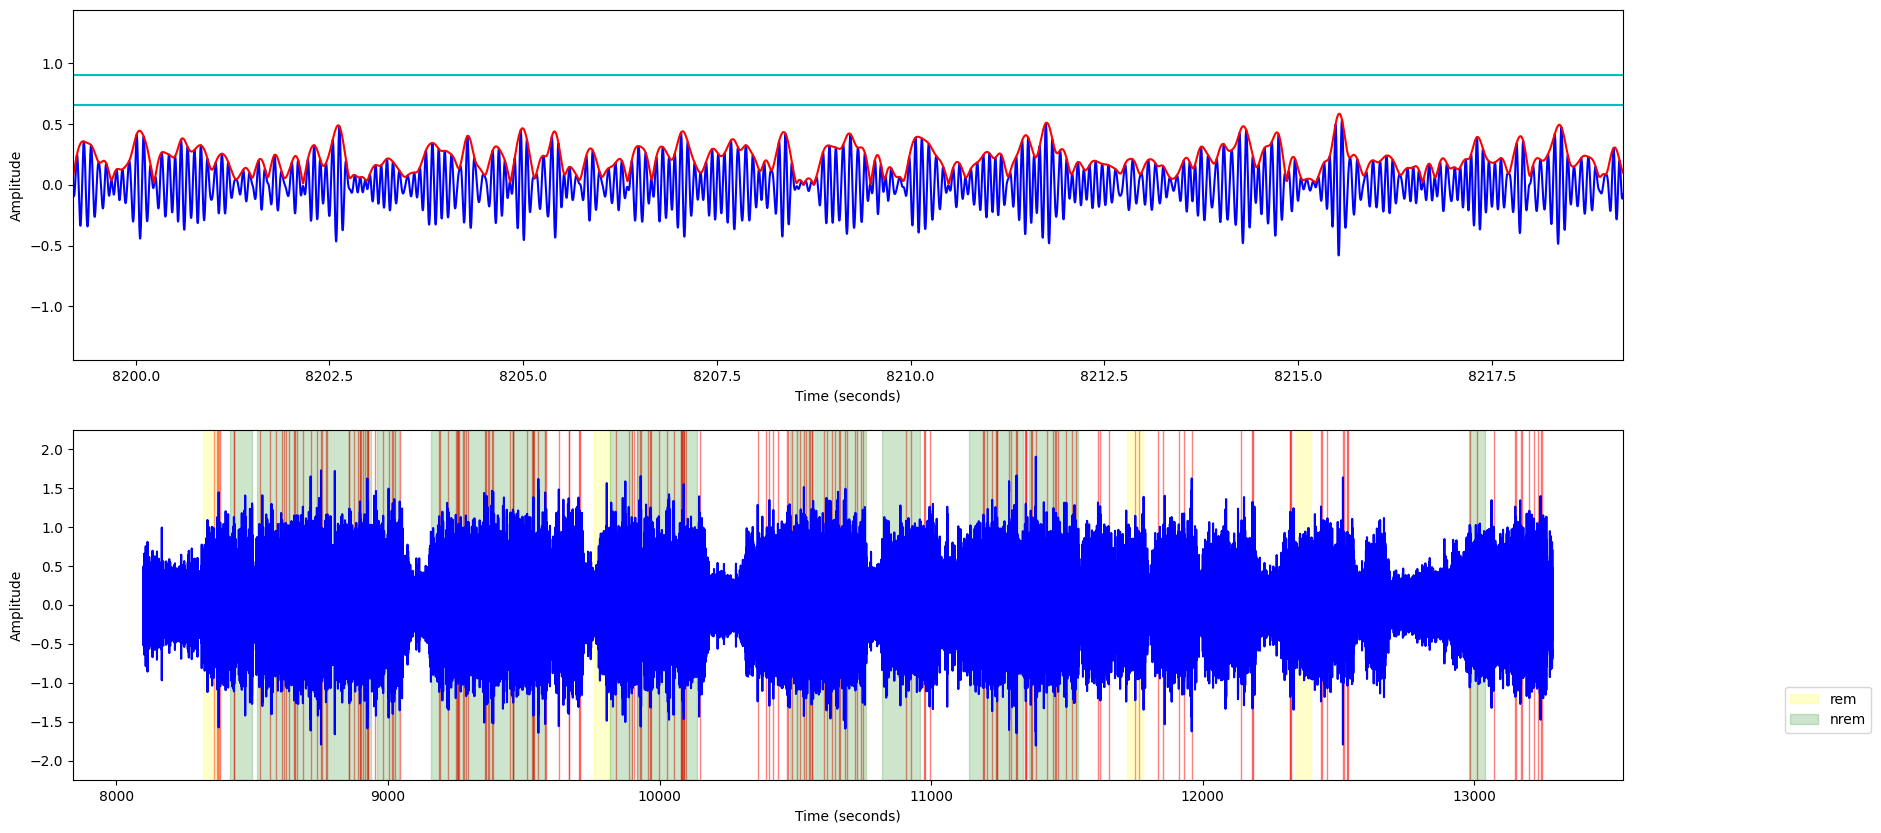

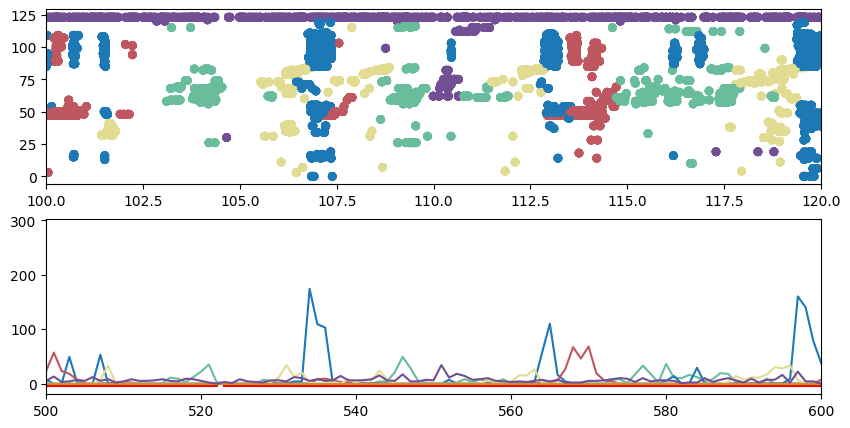

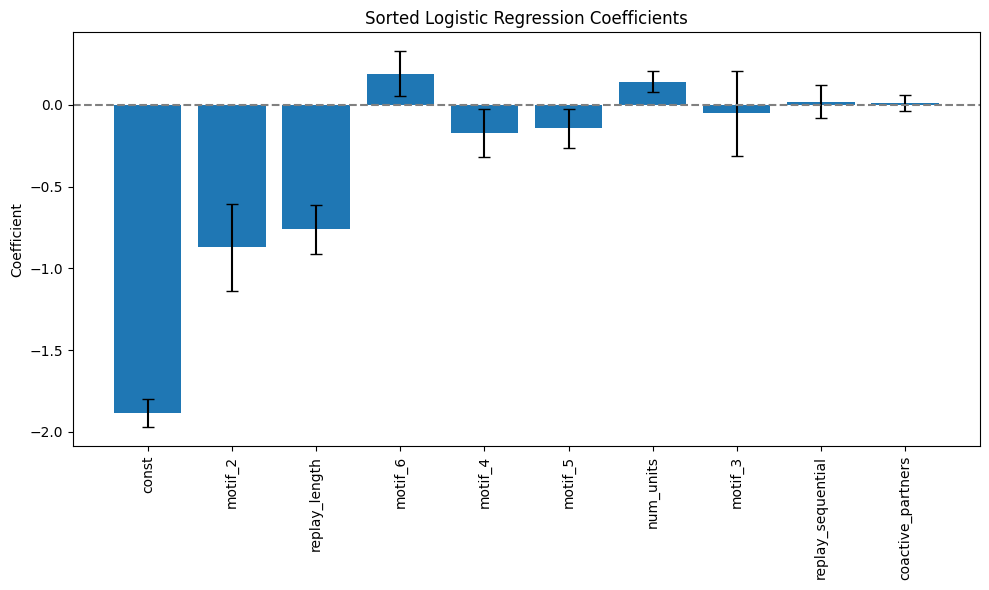

============================================= DONE ===================================================


<Figure size 640x480 with 0 Axes>

In [ ]:
data_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\"

for mouse in os.listdir(data_path):
    mouse_data_path = os.path.join(data_path,mouse) + r'\\processed_data\\'
    if not os.path.exists(mouse_data_path):
        print(f"Mouse {mouse} does not have processed data.")
        continue
    print( f'mouse name is: \033[1m{mouse}\033[0m')
    average_lfp = np.load(mouse_data_path + 'average_lfp.npy')
    
    ## load in sleep state scoring data
    nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data_bool = load_in_sleep_state_scoring(mouse)
    
    replay_events_df,replay_exists_bool = load_in_replay_data(mouse,old_data_bool)
    
    if replay_exists_bool == 'SKIP':
        print(f'ERROR! no replay data found for mouse {mouse}')
        print('================================================================================================')
        continue
        
    # load sync file
    behav_sync_file = load_sync_file(mouse_org_data_path,mouse)
    
    #make outpath
    output_path = os.path.join(data_path,mouse) + r'\analysis\\'
    # if path doesnt exist, make it
    if not os.path.exists(output_path):
        os.makedirs(output_path)
        
    # get the ephys time from the sleep because this is what the lfp was trimmed down to.                        
    sleep_period_ephys_start_time = behav_sync_file.Camera_time_Ephys_Aligned[0]
     
    ########## sleep onset
    rem_intervals = list(rem_start_ends - sleep_period_ephys_start_time)
    nrem_intervals = list(nrem_start_ends - sleep_period_ephys_start_time)
    # take the first items
    sleep_start_time = min([item[0] for item in (rem_intervals + nrem_intervals)])
    
    # SPINDLE IDENTIFICATION ##############################

    # load in spindle bandpassed data 
    spindle_bandpassed = np.load(mouse_data_path + 'zscored_spindle_bandpassed.npy')

    # find spindle events
    fs = 2500
    min_event_duration = 0.3 #s
    spindle_events,smoothed_envelope = filter_for_spindles_and_plot(spindle_bandpassed,nrem_start_ends,rem_start_ends,fs,min_event_duration,sleep_period_ephys_start_time)
    plt.savefig(output_path + 'spindle_identification.png')
    
    # save out spindle events
    np.save(output_path + 'spindle_events.npy',spindle_events)

    # SPINDLE REPLAY LINKAGE ANALYSIS ##############################

    ## reset index
    replay_events_df = replay_events_df.reset_index(drop = True)

    # account for cumulative chunk time, make cumulative list
    chunk_times = []
    for chunk_number in replay_events_df.chunk.unique()[0:-1]:
        chunk_ts = replay_events_df.chunk_time[np.where(replay_events_df.chunk == chunk_number)[0][0]]
        chunk_times += [np.diff(chunk_ts)[0]]
    cumulative_chunk_start_times = [0] + list(np.cumsum(chunk_times))

    # pull out replay times (first spike and mid points)
    replay_fs_times = []
    replay_mid_times  = []
    for index, chunktime in enumerate(replay_events_df.chunk_time):
        chunk_cumulative_offset = cumulative_chunk_start_times[replay_events_df.chunk[index] - 1]
        #relative replay time within all chunks
        rel_cumchunks_time = (replay_events_df.first_spike_time[index] - chunk_cumulative_offset)
        # replay time in ephys time
        replay_time_fs_ephys = rel_cumchunks_time + chunktime[0]
        replay_fs_times += [replay_time_fs_ephys]
        # half length of replay
        half_length = (replay_events_df.last_spike_time[index] - replay_events_df.first_spike_time[index])/2 
        replay_mid_times += [replay_time_fs_ephys + half_length]

    #accout for offset (i trimmed the lfp down to just the sleep period during preprocessing to make the data less heavy )
    replay_fs_times = replay_fs_times - sleep_period_ephys_start_time
    replay_mid_times = replay_mid_times - sleep_period_ephys_start_time

    # find spindle mid points
    spindle_start_points = []
    spindle_mid_points = []
    for spin_event in spindle_events:
        spin_length = spin_event['end_time'] - spin_event['start_time']
        spin_mid = (spin_event['start_time']-sleep_period_ephys_start_time) + (spin_length/2)
        spin_start = (spin_event['start_time']-sleep_period_ephys_start_time)
        spindle_start_points += [spin_start]
        spindle_mid_points += [spin_mid]


    # calcuate linkage distance - min distance between spindle and replay event for each replay
    spindle_linkage_distance  = define_spindle_linkage(spindle_start_points,replay_fs_times)


    ########################################################################################################################
    #ANALYSIS OF REPLAY FEATURES AND SPINDLE FEATURES
    ############# do features of replay preidct closeness to spindle? EXTRACT REPLAY FEATURES ##############################


    ppseq_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\\"
    sequence_order_df = pd.read_csv(ppseq_path+"sequence_order.csv")


    # pull out sequence order for current mouse
    seq_order= ast.literal_eval(sequence_order_df[sequence_order_df.mir == mouse].seq_order.values[0])
    num_dominant_seqs = int(sequence_order_df[sequence_order_df.mir == mouse].dominant_task_seqs)
    real_order = np.array(seq_order)+1

    #deal wih the fact that the way I order the sequence messes up the order a bit
    if not len(real_order) == num_dominant_seqs:
        dominant = list(real_order[0:num_dominant_seqs])
        other_ = list(real_order[num_dominant_seqs::])
    else:
        dominant = list(real_order)
        other_ = []

    ### load in awake ppseq data for mouse
    awake_file_path = find_awake_file_ppseq_path(mouse,ppseq_path)
    with open(awake_file_path + r'\analysis_output\\' + 'spikes_seq_type_adjusted.pickle', 'rb') as handle:
        unmasked_spikes_df = pickle.load(handle)
        
    with open(awake_file_path + r'\analysis_output\reordered_recolored\\' + 'neuron_order', 'rb') as handle:
        awake_neuron_order = pickle.load(handle)

    colors = pd.read_pickle(awake_file_path + r"\analysis_output\reordered_recolored\\" + 'colors')

    #load json
    import json
    params = None
    for file in os.listdir(awake_file_path + r'\trainingData\\'):
        if 'json' in file:
            param_path = os.path.join(awake_file_path + r'\trainingData\\', file)
            with open(param_path,'r') as f:
                params = json.load(f)
    awake_time_span = params['time_span'][0]

    # cluster the awake spikes into individual sequence events
    seq_event_dfs = process_awake_data_return_seq_dfs(unmasked_spikes_df,awake_time_span,awake_neuron_order,colors,[100,120])
        
    # Precompute static resources
    seq_by_seq_awake_mean_neuron_motif_involvements = determine_awake_neuron_motif_involvements(unmasked_spikes_df, seq_event_dfs)
    coactive_group_array = replay_events_df['coactive_cluster_group'].values
    all_seq_types = np.array(seq_order) + 1

    # Pre-parse columns that are stringified lists (only once)
    replay_events_df['parsed_spike_times'] = replay_events_df['cluster_spike_times'].apply(literal_eval)
    replay_events_df['parsed_neurons'] = replay_events_df['cluster_neurons'].apply(literal_eval)

    # Store all rows in a list
    rows = []

    for event_i in tqdm(range(len(replay_events_df))):
        row = replay_events_df.iloc[event_i]
        
        # Pre-parsed
        cluster_spike_times = row.parsed_spike_times
        cluster_neurons = np.array(row.parsed_neurons).astype(int)

        # Event properties
        current_event_length = max(cluster_spike_times) - min(cluster_spike_times)
        current_event_units = len(np.unique(cluster_neurons))
        current_event_spikes = len(cluster_spike_times)
        current_event_seq_type = row['cluster_seq_type']
        current_event_coactive_partners = np.sum(coactive_group_array == row['coactive_cluster_group']) - 1
        current_event_replay_type = 1 if row.ordering_classification == 'sequential' else 0
        current_event_rem_status = row.rem_events
        current_event_nrem_status = row.nrem_events
        current_event_task_related = int(current_event_seq_type in all_seq_types)

        # Time from sleep onset
        replay_time = row.chunk_time[0] + row.first_spike_ephys_time
        relative_time = replay_time - sleep_period_ephys_start_time
        current_event_time_from_sleep_onset = max(relative_time - sleep_start_time, 0)

        # Unit consistency
        neuron_involvements_awake = seq_by_seq_awake_mean_neuron_motif_involvements[current_event_seq_type - 1]
        neuron_indices = cluster_neurons - 1  # zero-indexed
        current_unit_consistency_awake = np.mean(np.array(neuron_involvements_awake)[neuron_indices])

        # Add to list
        rows.append({
            'replay_length': current_event_length,
            'num_units': current_event_units,
            'num_spikes': current_event_spikes,
            'motif_type': current_event_seq_type,
            'coactive_partners': current_event_coactive_partners,
            'replay_sequential': current_event_replay_type,
            'rem_status': current_event_rem_status,
            'nrem_status': current_event_nrem_status,
            'task_related': current_event_task_related,
            'time_from_sleep_onset': current_event_time_from_sleep_onset,
            'unit_consistency_awake': current_unit_consistency_awake
        })
        
    # Final DataFrame creation (fast and efficient)
    replay_features_df = pd.DataFrame(rows)
    
    # save this out 
    replay_features_df.to_csv(output_path + 'replay_features_df.csv', index=False)
    np.save(output_path+'spindle_linkage_distances.npy' ,spindle_linkage_distance)
    
    ################################################################################
    # step 1: 
    # regression of spindle linkage distance based on sequence type, 
    # keep the Rsquared and compare to shuffled data 
    ###############################################################################
    
    # only nrem?
    
    
    sequential_mask = replay_features_df['replay_sequential'].values == 1
    df = pd.DataFrame({
        'sequence_type': replay_features_df.motif_type.values[sequential_mask],
        'spindle_closeness': abs(np.array(spindle_linkage_distance)[sequential_mask])*-1 # multiply by -1 as we want to predict closeness to spindle (closer = more positive/less negative)
    })

    X = pd.get_dummies(df['sequence_type'], drop_first=True).astype(int)
    X = sm.add_constant(X)
    y = df['spindle_closeness']
    real_model = sm.OLS(y, X).fit()
    real_coefs = real_model.params.drop('const')  # exclude intercept

    real_model = sm.OLS(y, X).fit()
    real_r2 = real_model.rsquared

    ## shuffle
    n_permutations = 100
    shuffled_r2s = []

    for _ in range(n_permutations):
        y_shuffled = y.sample(frac=1, replace=False).reset_index(drop=True)
        shuffled_model = sm.OLS(y_shuffled, X).fit()
        shuffled_r2s.append(shuffled_model.rsquared)

    plt.hist(shuffled_r2s, bins=30, alpha=0.6, label='Shuffled')
    plt.axvline(real_r2, color='red', linestyle='--', label='Real R²')
    plt.xlabel('R²')
    plt.ylabel('Frequency')
    plt.title('Permutation Test for R²')
    plt.legend()
    plt.tight_layout()
    plt.show()


    ### save out the rsquared values
    np.save(output_path + 'replay_spindle_linkage_r2.npy', np.array(real_r2))
    np.save(output_path + 'replay_spindle_linkage_r2_shuffle.npy', shuffled_r2s)
    
    
    ##################################################################################################################################
    # step 2:#######################################################################################################
    # what actually expains this?
    # which sequences significantly predict replay. what are their coefficens? are they task related or not? 
    ################################################################################################################

    df = pd.DataFrame({
        'sequence_type': replay_features_df.motif_type.values,
        'spindle_closeness': abs(np.array(spindle_linkage_distance))*-1 # multiply by -1 as we want to predict closeness to spindle (closer = more positive/less negative)
    })
    sequence_replay_df = replay_features_df[replay_features_df['replay_sequential'] == 1].reset_index(drop=True)
    sequential_spin_coseness_df = pd.DataFrame({'spindle_closeness': df['spindle_closeness'][replay_features_df['replay_sequential'] == 1].reset_index(drop=True)})

    # Drop some features
    replay_features_df_dropped = sequence_replay_df.copy().drop(columns=['motif_type','replay_sequential'])

    X = replay_features_df_dropped
    y = sequential_spin_coseness_df['spindle_closeness']

    # Identify binary vs continuous features
    binary_cols = [col for col in X.columns if set(X[col].dropna().unique()).issubset({0, 1})]
    continuous_cols = [col for col in X.columns if col not in binary_cols]

    # Scale only continuous features
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled[continuous_cols] = scaler.fit_transform(X[continuous_cols])

    # Add intercept
    X_const = sm.add_constant(X_scaled)

    # Fit the model
    model = sm.OLS(y, X_const).fit()

    n_permutations = 1000
    r2_permuted = []

    for _ in range(n_permutations):
        y_permuted = np.random.permutation(y)
        model_perm = sm.OLS(y_permuted, X_const).fit()
        r2_permuted.append(model_perm.rsquared)

    # Real model R²
    real_r2 = model.rsquared

    plt.hist(r2_permuted, bins=30, alpha=0.6, label='Shuffled')
    plt.axvline(real_r2, color='red', linestyle='--', label='Real R²')
    plt.xlabel('R²')
    plt.ylabel('Frequency')
    plt.title('Permutation Test for R²')
    plt.legend()
    plt.tight_layout()
    plt.show()


    ###############################

    # Extract coefficients and confidence intervals
    coef = model.params
    conf = model.conf_int()
    conf.columns = ['ci_lower', 'ci_upper']

    # Combine into one DataFrame
    coef_df = pd.concat([coef, conf], axis=1)
    coef_df.columns = ['coef', 'ci_lower', 'ci_upper']
    coef_df = coef_df.reset_index().rename(columns={'index': 'variable'})

    # Optional: exclude intercept
    coef_df = coef_df[coef_df['variable'] != 'const']

    # Sort by magnitude if desired
    coef_df = coef_df.sort_values('coef')

    # Plot
    plt.figure(figsize=(8, len(coef_df) * 0.4))
    plt.errorbar(coef_df['coef'], coef_df['variable'],
                xerr=[coef_df['coef'] - coef_df['ci_lower'],
                    coef_df['ci_upper'] - coef_df['coef']],
                fmt='o')
    plt.axvline(0, color='grey', linestyle='--')
    plt.xlabel("Coefficient Value")
    plt.title("Regression Coefficients with 95% Confidence Intervals")
    plt.tight_layout()
    plt.show()

    ### save out data from this analysis
    # save out the r squared 
    np.save(output_path + 'general_replay_features_spindle_linkage_r2_regression.npy', np.array(real_r2))
    # save out permutation r squared
    np.save(output_path + 'general_replay_features_spindle_linkage_permutation_r2_regression.npy', np.array(r2_permuted))
    # save out the coefficients 
    coef_df.to_csv(output_path + 'general_replay_features_spindle_linkage_coefficients_regression_df.csv', index=False)
        
    
    
    print('============================================= DONE ===================================================')
    





In [158]:
np.load(output_path + 'spindle_events.npy',allow_pickle=True)[0]

{'start_time': 8358.513441203198,
 'end_time': 8358.850641203198,
 'peak_magnitude': 0.9833099404836737,
 'magnitude': 232.70819713226282,
 'average_magnitude': 0.9537221193945198}

In [153]:
spindle_events

[{'start_time': 8358.513441203198,
  'end_time': 8358.850641203198,
  'peak_magnitude': 0.9833099404836737,
  'magnitude': 232.70819713226282,
  'average_magnitude': 0.9537221193945198},
 {'start_time': 8372.179041203197,
  'end_time': 8372.509441203198,
  'peak_magnitude': 0.9686717188553111,
  'magnitude': 220.7101691149603,
  'average_magnitude': 0.9432058509186338},
 {'start_time': 8376.176641203198,
  'end_time': 8376.516641203198,
  'peak_magnitude': 1.5742193477060697,
  'magnitude': 747.6263776590549,
  'average_magnitude': 1.3047580761938131},
 {'start_time': 8379.727041203198,
  'end_time': 8380.143041203197,
  'peak_magnitude': 1.050073610569973,
  'magnitude': 338.2659809000916,
  'average_magnitude': 0.9948999438237989},
 {'start_time': 8432.461841203198,
  'end_time': 8432.785041203198,
  'peak_magnitude': 1.1414502210671327,
  'magnitude': 597.1625226655361,
  'average_magnitude': 1.0313687783515304},
 {'start_time': 8434.163041203197,
  'end_time': 8434.595441203197,
  

[{'start_time': 8358.513441203198,
  'end_time': 8358.850641203198,
  'peak_magnitude': 0.9833099404836737,
  'magnitude': 232.70819713226282,
  'average_magnitude': 0.9537221193945198},
 {'start_time': 8372.179041203197,
  'end_time': 8372.509441203198,
  'peak_magnitude': 0.9686717188553111,
  'magnitude': 220.7101691149603,
  'average_magnitude': 0.9432058509186338},
 {'start_time': 8376.176641203198,
  'end_time': 8376.516641203198,
  'peak_magnitude': 1.5742193477060697,
  'magnitude': 747.6263776590549,
  'average_magnitude': 1.3047580761938131},
 {'start_time': 8379.727041203198,
  'end_time': 8380.143041203197,
  'peak_magnitude': 1.050073610569973,
  'magnitude': 338.2659809000916,
  'average_magnitude': 0.9948999438237989},
 {'start_time': 8432.461841203198,
  'end_time': 8432.785041203198,
  'peak_magnitude': 1.1414502210671327,
  'magnitude': 597.1625226655361,
  'average_magnitude': 1.0313687783515304},
 {'start_time': 8434.163041203197,
  'end_time': 8434.595441203197,
  

In [ ]:
# decide which spindles are linked to replay and which are not

#make plots for these:


,replay_length,num_units,num_spikes,motif_type,coactive_partners,replay_sequential,rem_status,nrem_status,task_related,time_from_sleep_onset,unit_consistency_awake
100,0.1083,11,19,1,6,1,0,1,1,653.327859,0.559150
101,0.2823,7,31,1,6,1,0,1,1,653.971159,0.613495
102,0.1056,6,14,1,5,1,0,1,1,657.064559,0.605832
103,0.0315,6,7,1,6,1,0,1,1,668.296959,0.281782
104,0.0304,10,14,1,12,1,0,1,1,669.410359,0.438729
...,...,...,...,...,...,...,...,...,...,...,...
1201,0.7518,9,19,6,7,1,0,1,0,3164.123259,0.445419
1202,0.5744,7,13,6,3,1,0,1,0,3165.608059,0.485755
1203,2.3066,11,78,6,7,1,0,1,0,3194.177359,0.409782
1204,1.5699,12,30,6,4,1,0,1,0,3211.579659,0.322840


array([-13.4699588, -13.6611588,  -8.3730412, ..., -25.3382588,
       -27.7378412, -19.9127412])

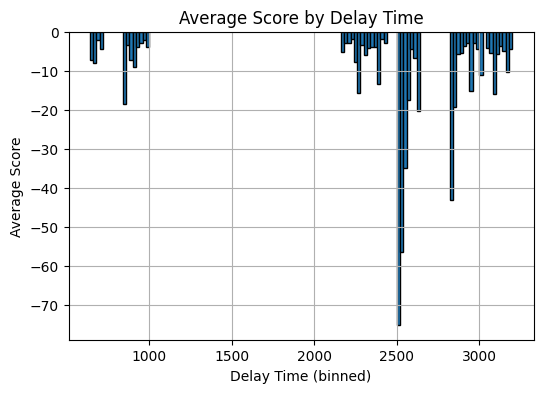

In [149]:
import numpy as np
import matplotlib.pyplot as plt

nrem_mask = sequence_replay_df.nrem_status == 1

# Example data
delay_times = sequence_replay_df.time_from_sleep_onset.values[nrem_mask]
scores = sequential_spin_coseness_df.spindle_closeness.values[nrem_mask]

# Define bins for delay times (e.g. every 0.5s)
bin_edges = np.arange(0, round(max(delay_times)), 20)

# Digitize: assigns each delay to a bin index
bin_indices = np.digitize(delay_times, bin_edges)

# Compute average score per bin
average_scores = []
bin_centers = []

for i in range(1, len(bin_edges)):
    in_bin = scores[bin_indices == i]
    if len(in_bin) > 0:
        average_scores.append(np.mean(in_bin))
        bin_centers.append((bin_edges[i-1] + bin_edges[i]) / 2)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(bin_centers, average_scores, width=np.diff(bin_edges)[0], align='center', edgecolor='black')
plt.xlabel('Delay Time (binned)')
plt.ylabel('Average Score')
plt.title('Average Score by Delay Time')
plt.grid(True)
plt.show()


In [142]:
np.diff(bin_edges)[0]

20

In [140]:
len(bin_centers)

138

In [139]:
len(average_scores)

138

In [138]:
average_scores

[-6.350826246399615,
 -5.796124918210968,
 -3.2537449999998898,
 -3.2133578065655333,
 -10.7777137968018,
 -34.04035586453402,
 -24.788477566833368,
 -9.686627869863758,
 -4.707743981409207,
 -1.1558006015986393,
 -2.0028625743372688,
 -6.150975081788548,
 -5.166674387612558,
 -7.223178934932396,
 -7.97794509269382,
 -2.0894063389534776,
 -4.512026388930158,
 -6.1901931982783935,
 -24.64734114974389,
 -47.785215046802705,
 -59.10082546346894,
 -57.849841203196775,
 -42.976334060340506,
 -18.59890483956108,
 -3.3742955064467157,
 -7.323351829637907,
 -9.08469202108341,
 -3.795814494028841,
 -3.0086384260272703,
 -2.071509066399585,
 -3.9556587968036183,
 -9.567457142857554,
 -4.832184721919111,
 -5.71533908708417,
 -5.137591600456809,
 -1.431461265600774,
 -12.831008796802962,
 -15.18814120319647,
 -3.296070569145221,
 -22.720258796803023,
 -49.911858796803244,
 -67.4751462968029,
 -79.29592546346976,
 -103.50735439840173,
 -91.95211620319878,
 -70.53946120319851,
 -54.45772120319816,
 

4180.021558796803

In [133]:
bin_centers

[]

In [132]:
delay_times

array([ 380.8107588,  381.0019588,  387.2221588, ..., 4164.8886588,
       4169.0473588, 4176.8724588])

,replay_length,num_units,num_spikes,motif_type,coactive_partners,replay_sequential,rem_status,nrem_status,task_related,time_from_sleep_onset,unit_consistency_awake
0,0.0557,6,13,1,7,1,0,0,1,380.810759,0.658080
1,0.0983,12,22,1,7,1,0,0,1,381.001959,0.472894
2,0.0516,10,13,1,8,0,0,0,1,383.735459,0.543402
3,0.1935,8,15,1,4,0,0,0,1,385.098359,0.609786
4,0.0197,10,20,1,8,0,0,0,1,386.027359,0.501835
...,...,...,...,...,...,...,...,...,...,...,...
4241,0.4616,7,16,6,9,1,0,0,0,4164.888659,0.059028
4242,2.1578,12,47,6,7,0,0,0,0,4166.415059,0.639086
4243,0.9066,5,14,6,6,1,0,0,0,4169.047359,0.595238
4244,2.0040,15,70,6,6,0,0,0,0,4172.204159,0.142328


In [120]:
pd.DataFrame({'spindle_closeness': df['spindle_closeness'][replay_features_df['replay_sequential'] == 1].reset_index(drop=True)})

,spindle_closeness
0,-13.469959
1,-13.661159
2,-8.373041
3,-2.677041
4,-1.953941
...,...
1396,-13.348359
1397,-16.256859
1398,-25.338259
1399,-27.737841


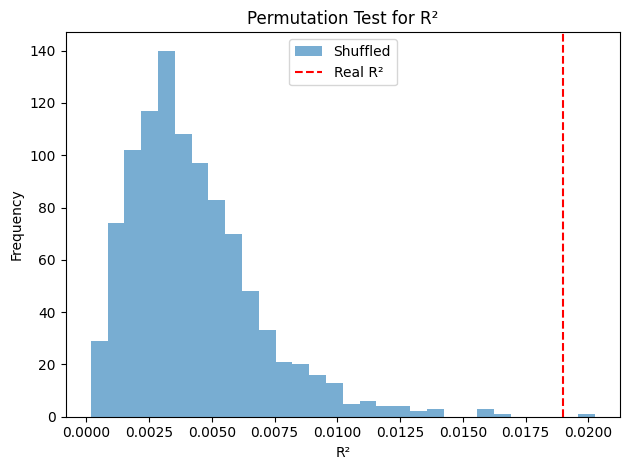

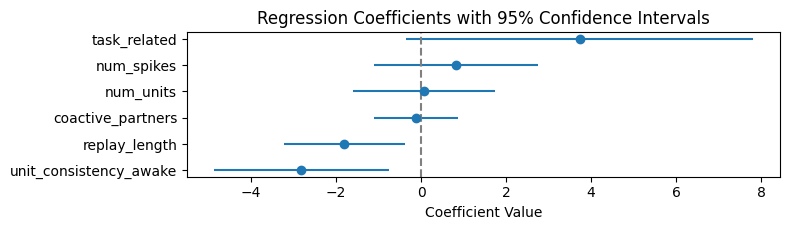

In [ ]:
##### REGRESSION 1: MOTIF TYPE

df = pd.DataFrame({
    'sequence_type': replay_features_df.motif_type.values,
    'spindle_closeness': abs(np.array(spindle_linkage_distance))*-1 # multiply by -1 as we want to predict closeness to spindle (closer = more positive/less negative)
})

X = pd.get_dummies(df['sequence_type'], drop_first=True).astype(int)
X = sm.add_constant(X)
y = df['spindle_closeness']
real_model = sm.OLS(y, X).fit()
real_coefs = real_model.params.drop('const')  # exclude intercept


n_permutations = 1000
coef_distributions = {col: [] for col in real_coefs.index}

for _ in range(n_permutations):
    y_shuffled = y.sample(frac=1, replace=False).reset_index(drop=True)
    shuffled_model = sm.OLS(y_shuffled, X).fit()
    for col in real_coefs.index:
        coef_distributions[col].append(shuffled_model.params[col])

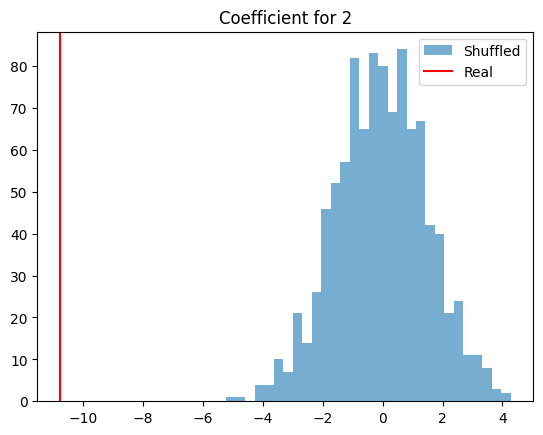

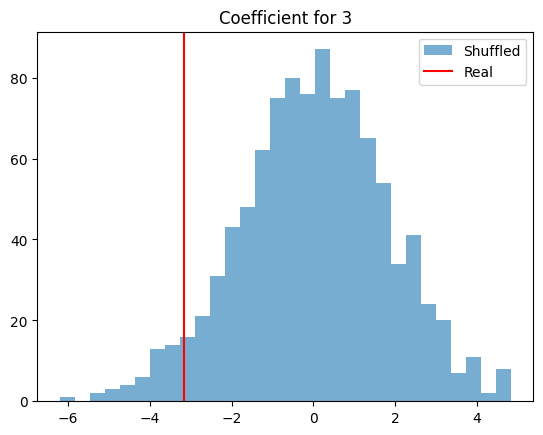

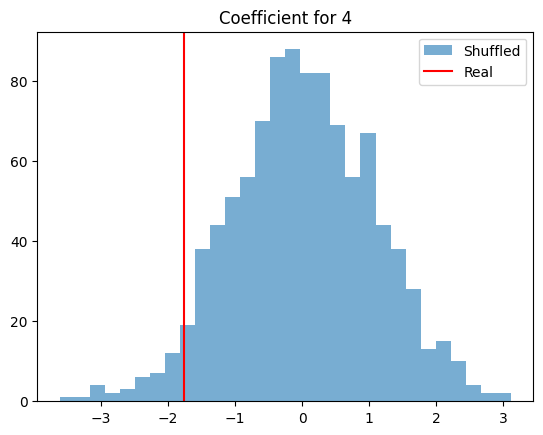

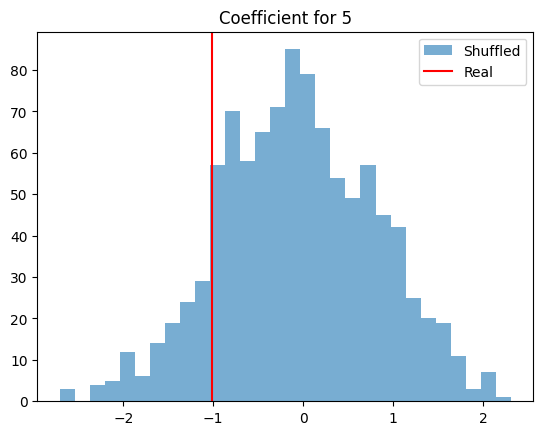

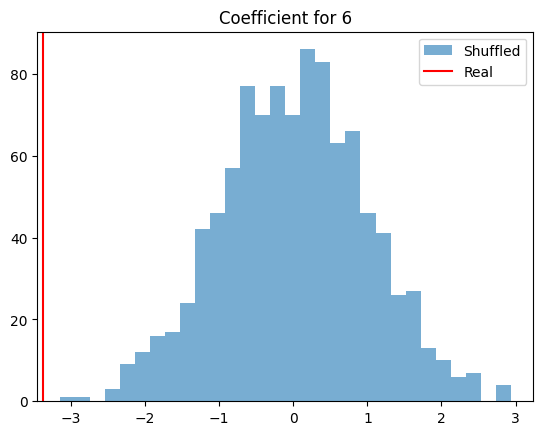

In [63]:
for col in real_coefs.index:
    plt.hist(coef_distributions[col], bins=30, alpha=0.6, label='Shuffled')
    plt.axvline(real_coefs[col], color='red', label='Real')
    plt.title(f"Coefficient for {col}")
    plt.legend()
    plt.show()

In [59]:
y = df['spindle_closeness']

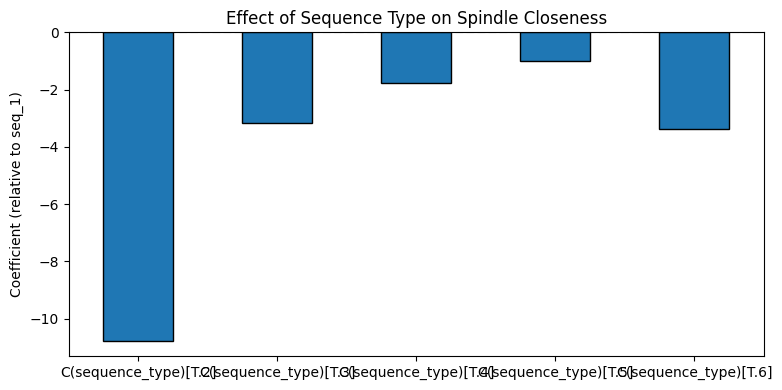

In [ ]:
# Extract coefficients (excluding the intercept if desired)
coefs = model.params.drop('Intercept')  # or keep it in if you want to show the intercept too

# Plot
plt.figure(figsize=(8, 4))
coefs.plot(kind='bar', edgecolor='black')
plt.axhline(0, color='gray', linestyle='--')
plt.ylabel('Coefficient (relative to seq_1)')
plt.title('Effect of Sequence Type on Spindle Closeness')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [65]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder

# One-hot encode
X = OneHotEncoder(drop='first', sparse_output=False).fit_transform(df[['sequence_type']])
y = df['spindle_closeness']

# Fit Lasso with cross-validation
model = LassoCV(cv=5).fit(X, y)

# Coefficients
nonzero = (model.coef_ != 0)
print(f"{nonzero.sum()} out of {X.shape[1]} sequence types kept")

2 out of 5 sequence types kept


In [67]:
model.coef_

array([-7.40493682, -0.        , -0.        ,  0.        , -1.56600892])

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

results = []

for t in sorted(df['sequence_type'].unique()):
    df[f'is_seq_{t}'] = (df['sequence_type'] == t).astype(int)
    X = df[[f'is_seq_{t}']]
    y = df['spindle_closeness']

    model = LinearRegression().fit(X, y)
    r2 = r2_score(y, model.predict(X))
    coef = model.coef_[0]
    results.append((t, coef, r2))


In [69]:
for t, coef, r2 in results:
    print(f"Sequence {t}: coef = {coef:.3f}, R² = {r2:.3f}")


Sequence 1: coef = 2.701, R² = 0.003
Sequence 2: coef = -9.434, R² = 0.010
Sequence 3: coef = -1.345, R² = 0.000
Sequence 4: coef = 0.118, R² = 0.000
Sequence 5: coef = 1.138, R² = 0.001
Sequence 6: coef = -1.868, R² = 0.001


In [70]:

import statsmodels.api as sm

results = []

for t in sorted(df['sequence_type'].unique()):
    df[f'is_seq_{t}'] = (df['sequence_type'] == t).astype(int)
    X = sm.add_constant(df[[f'is_seq_{t}']])
    y = df['spindle_closeness']

    model = sm.OLS(y, X).fit()
    coef = model.params[1]
    pval = model.pvalues[1]
    r2 = model.rsquared
    results.append((t, coef, pval, r2))


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_61896\3934034733.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = model.params[1]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_61896\3934034733.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval = model.pvalues[1]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_61896\3934034733.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = model.para

In [71]:
for t, coef, pval, r2 in results:
    print(f"Sequence {t}: coef = {coef:.3f}, p = {pval:.3f}, R² = {r2:.3f}")


Sequence 1: coef = 2.701, p = 0.000, R² = 0.003
Sequence 2: coef = -9.434, p = 0.000, R² = 0.010
Sequence 3: coef = -1.345, p = 0.454, R² = 0.000
Sequence 4: coef = 0.118, p = 0.897, R² = 0.000
Sequence 5: coef = 1.138, p = 0.123, R² = 0.001
Sequence 6: coef = -1.868, p = 0.025, R² = 0.001


In [ ]:

    # drop some columns that are not needed for the regression analysis
    replay_features_df_dropped = replay_features_df.drop(columns=['num_spikes', 'rem_status','nrem_status','task_related','time_from_sleep_onset','unit_consistency_awake'])

    # spindle linkage distance was defined earlier, make it into a binary, logisitic outcome variable:
    spindle_linkage_bool = (abs(np.array(spindle_linkage_distance))< 1.5).astype(int) 


    # Separate target and predictors
    y = pd.DataFrame({'spindle_linage_binary':spindle_linkage_bool})
    X = replay_features_df_dropped.copy()

    ### one hot encode the motif_type (categorical variable)
    # Convert motif_type to string (optional, for clarity)
    replay_features_df_dropped['motif_type'] = replay_features_df_dropped['motif_type'].astype(str)
    # Create dummy variables
    motif_dummies = pd.get_dummies(replay_features_df_dropped['motif_type'], prefix='motif', drop_first=True)
    # Drop original column and replace with dummies
    X = replay_features_df_dropped.drop(columns=['motif_type'])
    X = pd.concat([X, motif_dummies.astype(int)], axis=1)

    ### SCALE THE FEATURES
    # Identify binary vs continuous features
    binary_cols = [col for col in X.columns if set(X[col].dropna().unique()).issubset({0, 1})]
    continuous_cols = [col for col in X.columns if col not in binary_cols]
    # Scale only continuous features
    scaler = StandardScaler()
    X_scaled = X.copy()
    X_scaled[continuous_cols] = scaler.fit_transform(X[continuous_cols])

    # Add intercept
    X_const = sm.add_constant(X_scaled)

    # Fit model
    logit_model = sm.Logit(y, X_const)
    results = logit_model.fit()
    print(results.summary())

    # save out the results object 
    with open(output_path + 'replay_predicts_linkage_logistic_regression_results_object.pkl', 'wb') as f:
        pickle.dump(results, f)
        

    ###### plot the coefficients of the logistic regression model

    sorted_coefs = results.params.reindex(results.params.abs().sort_values(ascending=False).index)
    sorted_errors = results.bse[sorted_coefs.index]

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_coefs.index, sorted_coefs.values, yerr=sorted_errors.values, capsize=4)
    plt.axhline(0, color='gray', linestyle='--')
    plt.xticks(rotation=90)
    plt.ylabel('Coefficient')
    plt.title('Sorted Logistic Regression Coefficients')
    plt.tight_layout()
    plt.show()

    #save this fig 
    plt.savefig(output_path + 'logistic_regression_coefficients.png')

    ########## AUCs ########################

    # Get predicted probabilities for the original data
    y_pred_proba = results.predict(X_const)

    # Calculate AUC for the original data
    original_auc = roc_auc_score(y, y_pred_proba)
    # save this out 
        
    with open(output_path + 'replay_predicts_linkage_original_auc.txt', 'w') as f:
        f.write(str(original_auc))

    # 4. Shuffle y and compute AUC for each shuffle
    n_shuffles = 100
    shuffled_aucs = []

    for _ in range(n_shuffles):
        y_shuffled = shuffle(y)  # Shuffle the target variable
        y_shuffled = y_shuffled.reset_index(drop=True)  # Reset index after shuffle
        logit_model_shuffled = sm.Logit(y_shuffled, X_const)  # Refit the model with shuffled data
        results_shuffled = logit_model_shuffled.fit(disp=False)
        y_pred_proba_shuffled = results_shuffled.predict(X_const)  # Get predicted probabilities
        auc_shuffled = roc_auc_score(y_shuffled, y_pred_proba_shuffled)
        shuffled_aucs.append(auc_shuffled)

    # save out shuffled AUCs 
    with open(output_path + 'replay_predicts_linkage_shuffled_aucs.pkl', 'wb') as f:
        pickle.dump(shuffled_aucs, f)
        
        
        
    print('============================================= DONE ===================================================')

    break